<a href="https://colab.research.google.com/github/edcalderin/Competencia_Puntaje_Recencia/blob/master/Competencia_Puntaje_Recencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook create by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# For ML
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing data

Getting training and test datasets from Drive.

In [4]:
# Train
PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
train = pd.read_csv(PREFIX+'/Train.csv')
test = pd.read_csv(PREFIX+'/Test.csv')

## Exploring

In [5]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [6]:
train.rename(columns={'total_rel_score':'score'}, inplace=True)
print('New columns', train.columns)

New columns Index(['id', 'Language', 'Year', 'Abstract', 'Title', 'score'], dtype='object')


In [7]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [8]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [9]:
train.isna().sum()

id          0
Language    0
Year        0
Abstract    0
Title       0
score       0
dtype: int64

Score distribution for each language

Text(0.5, 1.0, 'Histogram of Score by Language')

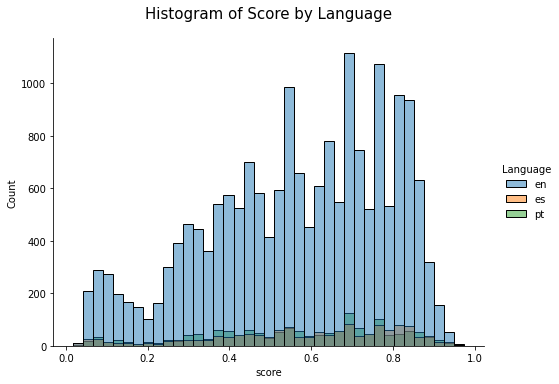

In [10]:
sns.displot(data=train, x= 'score', aspect=1.4, hue='Language')
plt.title('Histogram of Score by Language', fontsize=15, pad=20)

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome rest of remaining of languages.

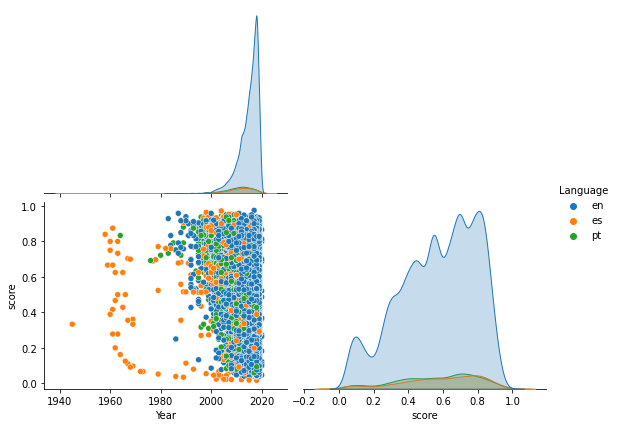

In [11]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [12]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [13]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_))

Dropping unnecessary columns:

In [14]:
COLS = ['id', 'Language', 'Abstract', 'Title']
train.drop(COLS, axis=1, inplace=True)

In [15]:
train.head()

,Year,score,"(en,)","(es,)","(pt,)"
0,2016,0.630682,1,0,0
1,2019,0.583333,1,0,0
2,2019,0.372222,1,0,0
3,2017,0.661765,1,0,0
4,2015,0.373737,1,0,0


In [16]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

Ready for training!

## Training

In [17]:
X = train.drop(['score'], axis=1)
y = train.score

In [18]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, shuffle=True)

Let's begin with a classic regressor 'Linear Regression' in order to find out our first score.

In [19]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # RMSE metric
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSE Train', rmse_train)
    print('RMSE Test', rmse_test)

RMSE Train 0.2137853200913345
RMSE Test 0.2138782419999961


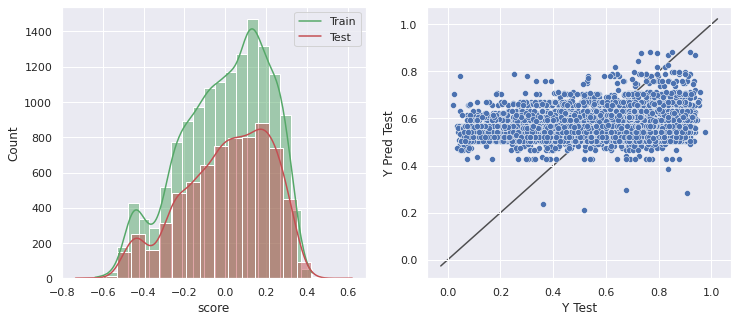

In [22]:
results_metric(model)

## Predictions

Preprocessing Test dataset

In [23]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_)

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [24]:
id = test.id

Removing same columns as train dataset:

In [25]:
test.drop(COLS, axis=1, inplace=True)

In [26]:
y_pred = model.predict(test)
predictions = pd.DataFrame({'id':id, 'scototal_rel_score':y_pred})
predictions.head()

,id,scototal_rel_score
0,1,0.551976
1,2,0.551976
2,3,0.551976
3,4,0.563158
4,5,0.551976


In [40]:
predictions.to_csv(PREFIX+'/SampleSubmission.csv')